# Environment

> Get topics for each decade (folder-by-folder, basically)

References: 
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
https://medium.com/dataseries/understanding-pointwise-mutual-information-in-nlp-e4ef75ecb57a
https://www.baeldung.com/cs/topic-modeling-coherence-score

In [ ]:
%%capture
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

In [2]:
import re
import spacy
import gensim
import logging
import warnings
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from pprint import pprint
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader
from gensim.parsing.preprocessing import preprocess_string

%matplotlib inline
pyLDAvis.enable_notebook()
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Functions

In [3]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [4]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [5]:
# Setence to Words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    @param dictionary : Gensim dictionary
    @param corpus : Gensim corpus
    @param texts : List of input texts
    @param limit : Max num of topics

    @return model_list : List of LDA topic models
    @return coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list = []
    c_npmi_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=500, passes=5, alpha='auto', per_word_topics=True)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi')
        c_npmi_values.append(coherencemodel.get_coherence())
        model_list.append(model)

    return model_list, c_npmi_values

In [22]:
def draw_graph(start, limit, step, c_npmi):
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_npmi)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_npmi"), loc='best')
    plt.show()
    # Print the coherence scores
    minimum = max(c_npmi)
    indices = [i for i, v in enumerate(c_npmi) if v == minimum]
    print("A maximum {} score of {} was achieved at K={}".format("c_npmi", minimum, indices[0]+2))
    
    for m, cv in zip(x, c_npmi):
        print("Number of topics =", m, " has NPMI coherence Value of", round(cv, 4))

# Checking Coherence

In [9]:
corpus_root = "TRANSFORMED/2020-2029"
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

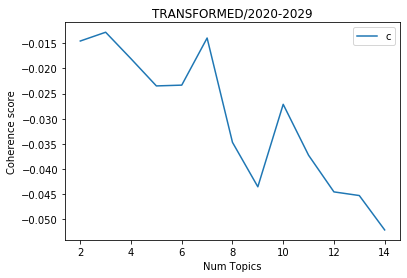

A maximum c_npmi score of -0.012830255675770253 was achieved at K=3
Number of topics = 2  has NPMI coherence Value of -0.0146
Number of topics = 3  has NPMI coherence Value of -0.0128
Number of topics = 4  has NPMI coherence Value of -0.0181
Number of topics = 5  has NPMI coherence Value of -0.0235
Number of topics = 6  has NPMI coherence Value of -0.0233
Number of topics = 7  has NPMI coherence Value of -0.014
Number of topics = 8  has NPMI coherence Value of -0.0347
Number of topics = 9  has NPMI coherence Value of -0.0435
Number of topics = 10  has NPMI coherence Value of -0.0272
Number of topics = 11  has NPMI coherence Value of -0.0373
Number of topics = 12  has NPMI coherence Value of -0.0445
Number of topics = 13  has NPMI coherence Value of -0.0453
Number of topics = 14  has NPMI coherence Value of -0.0521


In [24]:
draw_graph(start, limit, step, c_npmi)

In [26]:
corpus_root='TRANSFORMED/2010-2019'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.
    
# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

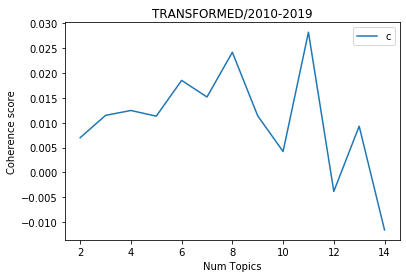

A maximum c_npmi score of 0.028229420387700675 was achieved at K=11
Number of topics = 2  has NPMI coherence Value of 0.007
Number of topics = 3  has NPMI coherence Value of 0.0115
Number of topics = 4  has NPMI coherence Value of 0.0125
Number of topics = 5  has NPMI coherence Value of 0.0113
Number of topics = 6  has NPMI coherence Value of 0.0185
Number of topics = 7  has NPMI coherence Value of 0.0152
Number of topics = 8  has NPMI coherence Value of 0.0242
Number of topics = 9  has NPMI coherence Value of 0.0114
Number of topics = 10  has NPMI coherence Value of 0.0042
Number of topics = 11  has NPMI coherence Value of 0.0282
Number of topics = 12  has NPMI coherence Value of -0.0038
Number of topics = 13  has NPMI coherence Value of 0.0093
Number of topics = 14  has NPMI coherence Value of -0.0116


In [27]:
draw_graph(start, limit, step, c_npmi)

In [28]:
corpus_root='TRANSFORMED/2000-2009'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

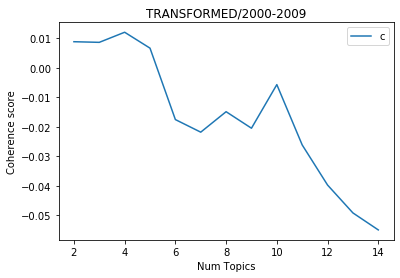

A maximum c_npmi score of 0.012055401426209264 was achieved at K=4
Number of topics = 2  has NPMI coherence Value of 0.0088
Number of topics = 3  has NPMI coherence Value of 0.0086
Number of topics = 4  has NPMI coherence Value of 0.0121
Number of topics = 5  has NPMI coherence Value of 0.0067
Number of topics = 6  has NPMI coherence Value of -0.0176
Number of topics = 7  has NPMI coherence Value of -0.0218
Number of topics = 8  has NPMI coherence Value of -0.0149
Number of topics = 9  has NPMI coherence Value of -0.0205
Number of topics = 10  has NPMI coherence Value of -0.0057
Number of topics = 11  has NPMI coherence Value of -0.0262
Number of topics = 12  has NPMI coherence Value of -0.0398
Number of topics = 13  has NPMI coherence Value of -0.0492
Number of topics = 14  has NPMI coherence Value of -0.055


In [29]:
draw_graph(start, limit, step, c_npmi)

In [30]:
corpus_root='TRANSFORMED/1990-1999'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

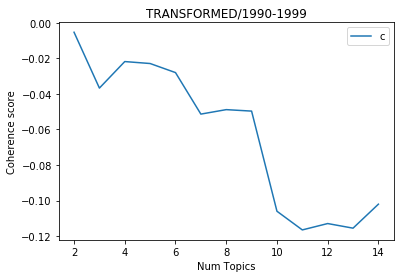

A maximum c_npmi score of -0.005327989376498386 was achieved at K=2
Number of topics = 2  has NPMI coherence Value of -0.0053
Number of topics = 3  has NPMI coherence Value of -0.0367
Number of topics = 4  has NPMI coherence Value of -0.0218
Number of topics = 5  has NPMI coherence Value of -0.0229
Number of topics = 6  has NPMI coherence Value of -0.028
Number of topics = 7  has NPMI coherence Value of -0.0514
Number of topics = 8  has NPMI coherence Value of -0.0488
Number of topics = 9  has NPMI coherence Value of -0.0497
Number of topics = 10  has NPMI coherence Value of -0.106
Number of topics = 11  has NPMI coherence Value of -0.1165
Number of topics = 12  has NPMI coherence Value of -0.1129
Number of topics = 13  has NPMI coherence Value of -0.1155
Number of topics = 14  has NPMI coherence Value of -0.102


In [31]:
draw_graph(start, limit, step, c_npmi)

In [32]:
corpus_root='TRANSFORMED/1980-1989'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

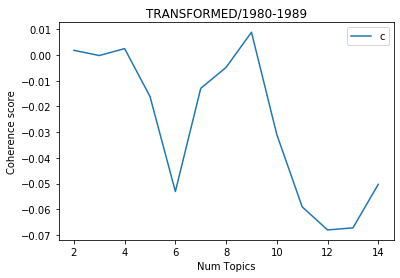

A maximum c_npmi score of 0.008892001303347143 was achieved at K=9
Number of topics = 2  has NPMI coherence Value of 0.0019
Number of topics = 3  has NPMI coherence Value of -0.0002
Number of topics = 4  has NPMI coherence Value of 0.0025
Number of topics = 5  has NPMI coherence Value of -0.0161
Number of topics = 6  has NPMI coherence Value of -0.0531
Number of topics = 7  has NPMI coherence Value of -0.0129
Number of topics = 8  has NPMI coherence Value of -0.0048
Number of topics = 9  has NPMI coherence Value of 0.0089
Number of topics = 10  has NPMI coherence Value of -0.0309
Number of topics = 11  has NPMI coherence Value of -0.0591
Number of topics = 12  has NPMI coherence Value of -0.068
Number of topics = 13  has NPMI coherence Value of -0.0672
Number of topics = 14  has NPMI coherence Value of -0.0503


In [33]:
draw_graph(start, limit, step, c_npmi)

In [34]:
corpus_root='TRANSFORMED/1970-1979'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

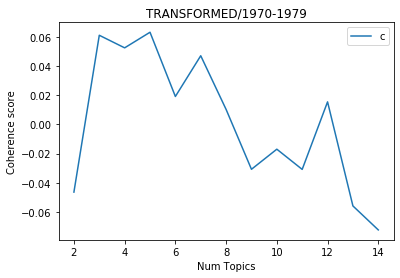

A maximum c_npmi score of 0.06313936685988132 was achieved at K=5
Number of topics = 2  has NPMI coherence Value of -0.0465
Number of topics = 3  has NPMI coherence Value of 0.0611
Number of topics = 4  has NPMI coherence Value of 0.0524
Number of topics = 5  has NPMI coherence Value of 0.0631
Number of topics = 6  has NPMI coherence Value of 0.0191
Number of topics = 7  has NPMI coherence Value of 0.047
Number of topics = 8  has NPMI coherence Value of 0.0102
Number of topics = 9  has NPMI coherence Value of -0.0308
Number of topics = 10  has NPMI coherence Value of -0.017
Number of topics = 11  has NPMI coherence Value of -0.0309
Number of topics = 12  has NPMI coherence Value of 0.0154
Number of topics = 13  has NPMI coherence Value of -0.056
Number of topics = 14  has NPMI coherence Value of -0.0724


In [35]:
draw_graph(start, limit, step, c_npmi)

In [36]:
corpus_root='TRANSFORMED/1960-1969'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

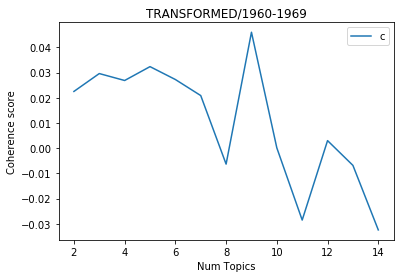

A maximum c_npmi score of 0.04597809470054558 was achieved at K=9
Number of topics = 2  has NPMI coherence Value of 0.0225
Number of topics = 3  has NPMI coherence Value of 0.0296
Number of topics = 4  has NPMI coherence Value of 0.0268
Number of topics = 5  has NPMI coherence Value of 0.0323
Number of topics = 6  has NPMI coherence Value of 0.0272
Number of topics = 7  has NPMI coherence Value of 0.0209
Number of topics = 8  has NPMI coherence Value of -0.0063
Number of topics = 9  has NPMI coherence Value of 0.046
Number of topics = 10  has NPMI coherence Value of 0.0001
Number of topics = 11  has NPMI coherence Value of -0.0285
Number of topics = 12  has NPMI coherence Value of 0.003
Number of topics = 13  has NPMI coherence Value of -0.0068
Number of topics = 14  has NPMI coherence Value of -0.0324


In [37]:
draw_graph(start, limit, step, c_npmi)

In [38]:
corpus_root='TRANSFORMED/1950-1959'
rows = []
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
text_list = corpus.fileids()
for text in text_list:
    if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
        identifier = text.split("_")[0]
    else:
        identifier = text.split("_")[-1][:-4]
    rows.append([identifier, " ".join(corpus.words(text))])
# CREATE DATFRAME
df = pd.DataFrame.from_records(rows, columns=['id', 'content'])

# CLEANING
# Convert to list
data = df['content'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Sentence to words
data_words = list(sent_to_words(data))

# BUILD THE BIGRAM AND TRIGRAM MODELS
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Can take a long time to run.

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

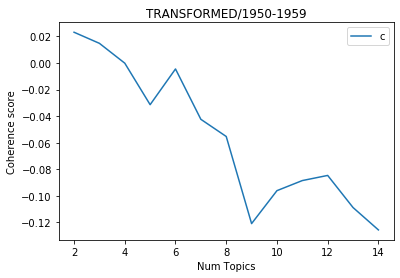

A maximum c_npmi score of 0.023179831532046166 was achieved at K=2
Number of topics = 2  has NPMI coherence Value of 0.0232
Number of topics = 3  has NPMI coherence Value of 0.0148
Number of topics = 4  has NPMI coherence Value of -0.0001
Number of topics = 5  has NPMI coherence Value of -0.0314
Number of topics = 6  has NPMI coherence Value of -0.0045
Number of topics = 7  has NPMI coherence Value of -0.0424
Number of topics = 8  has NPMI coherence Value of -0.0553
Number of topics = 9  has NPMI coherence Value of -0.1209
Number of topics = 10  has NPMI coherence Value of -0.0961
Number of topics = 11  has NPMI coherence Value of -0.0885
Number of topics = 12  has NPMI coherence Value of -0.0847
Number of topics = 13  has NPMI coherence Value of -0.1089
Number of topics = 14  has NPMI coherence Value of -0.1257


In [39]:
draw_graph(start, limit, step, c_npmi)

# Final Model

In [40]:
corpus_topics = {
  'TRANSFORMED/1950-1959':2,
  'TRANSFORMED/1960-1969':9,
  'TRANSFORMED/1970-1979':5,
  'TRANSFORMED/1980-1989':9,
  'TRANSFORMED/1990-1999':2,
  'TRANSFORMED/2000-2009':4,
  'TRANSFORMED/2010-2019':11,
  'TRANSFORMED/2020-2029':3
}

In [41]:
for corpus_root, topics_number in corpus_topics.items():
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics_number, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
    
    # Print the Keyword in the 10 topics
#     pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    
    # Compute Perplexity - a measure of how good the model is; Lower the better.
    perplexity = lda_model.log_perplexity(corpus)
#     print('\nPerplexity: ', perplexity)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_npmi')
    coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)
    
    # Write the results to a file
    file_name = corpus_root.split("/")[1]
    with open('LDA/'+file_name+'.txt', 'w') as f:
        f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))
    
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')
    print("Completed writing for {}.".format(file_name))
print("*"*20+"FINISHED"+"*"*20)

Completed writing for 1950-1959.
Completed writing for 1960-1969.
Completed writing for 1970-1979.
Completed writing for 1980-1989.
Completed writing for 1990-1999.
Completed writing for 2000-2009.
Completed writing for 2010-2019.
Completed writing for 2020-2029.
********************FINISHED********************


# Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [42]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [43]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9996,"people, s, think, go, re, thing, ve, campaign,...",sleep procrastinate better money 2021what terr...
1,1,2.0,0.9997,"people, s, think, go, re, thing, ve, campaign,...",interview british discuss making infusing elec...
2,2,0.0,0.9997,"company, people, report, health, system, gover...",immersive audio pieces automated phone system ...
3,3,0.0,0.8133,"company, people, report, health, system, gover...",youre smart devices something trysmart means d...
4,4,1.0,0.8465,"people, worker, company, state, year, program,...",tooleven youre generally smarthome devices sma...
5,5,1.0,0.5580,"people, worker, company, state, year, program,...",simple steps waysmarthome devices create comfo...
6,6,2.0,0.9997,"people, s, think, go, re, thing, ve, campaign,...",system meant judges courts novak djokovic play...
7,7,2.0,0.9997,"people, s, think, go, re, thing, ve, campaign,...",system meant judges courts novak djokovic play...
8,8,0.0,0.9997,"company, people, report, health, system, gover...",drivers passengers motorcyclists killed reckle...
9,9,0.0,0.9997,"company, people, report, health, system, gover...",enlarge imagetaichung taiwan gyms closed could...


# Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 

So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                     axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9999,"company, people, report, health, system, gover...",boeing 737 crashed amsterdam decade dutch inve...
1,1.0,0.9999,"people, worker, company, state, year, program,...",audio stories publishers download audm iphone ...
2,2.0,1.0000,"people, s, think, go, re, thing, ve, campaign,...",interview conducted editorial board announce d...


The above has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

# Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [45]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"people, s, think, go, re, thing, ve, campaign,...",161.0,0.3908
1.0,2.0,"people, s, think, go, re, thing, ve, campaign,...",145.0,0.3519
2.0,0.0,"company, people, report, health, system, gover...",106.0,0.2573
3.0,0.0,"company, people, report, health, system, gover...",NaN,NaN
4.0,1.0,"people, worker, company, state, year, program,...",NaN,NaN
...,...,...,...,...
407.0,1.0,"people, worker, company, state, year, program,...",NaN,NaN
408.0,1.0,"people, worker, company, state, year, program,...",NaN,NaN
409.0,0.0,"company, people, report, health, system, gover...",NaN,NaN
410.0,0.0,"company, people, report, health, system, gover...",NaN,NaN
